# Typing Error Analysis - MonkeyType Data

This notebook analyzes typing performance data from MonkeyType sessions to identify error patterns and provide improvement recommendations.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
import json
from matplotlib.colors import LinearSegmentedColormap

# Set styling for better visualization
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## Data Loading and Preparation

We'll start by loading the MonkeyType typing data and preparing it for analysis.

In [4]:
data = {}
with open("monkeytype_data.json") as f:
    data = json.load(f)

In [5]:
# Transform the data for analysis
all_words = []
for session in data:
    session_time = datetime.fromisoformat(session["time"].replace("Z", "+00:00"))
    for word_data in session["words"]:
        word_entry = {
            "session_id": session["id"],
            "session_time": session_time,
            "word": word_data["word"],
            "reason": word_data["reason"],
            "word_length": len(word_data["word"])
        }
        all_words.append(word_entry)

# Create a DataFrame for analysis
df = pd.DataFrame(all_words)

# Display the first few rows of the dataset
print("Dataset Overview:")
df.head()

Dataset Overview:


,session_id,session_time,word,reason,word_length
0,1740473661051,2025-02-25 08:54:21.051000+00:00,world,corrected,5
1,1740473661051,2025-02-25 08:54:21.051000+00:00,large,corrected,5
2,1740473661051,2025-02-25 08:54:21.051000+00:00,early,corrected,5
3,1740473661051,2025-02-25 08:54:21.051000+00:00,year,corrected,4
4,1740473661051,2025-02-25 08:54:21.051000+00:00,after,error,5


## Basic Statistics

Let's calculate some basic statistics about the typing performance.

In [6]:
# Basic statistics
total_words = len(df)
error_words = len(df[df['reason'] == 'error'])
corrected_words = len(df[df['reason'] == 'corrected'])
error_rate = error_words / total_words * 100
correction_rate = corrected_words / total_words * 100

print(f"\nTotal Words Typed: {total_words}")
print(f"Error Words: {error_words} ({error_rate:.2f}%)")
print(f"Corrected Words: {corrected_words} ({correction_rate:.2f}%)")

# Session analysis
sessions = df['session_id'].unique()
print(f"\nNumber of Typing Sessions: {len(sessions)}")


Total Words Typed: 351
Error Words: 200 (56.98%)
Corrected Words: 151 (43.02%)

Number of Typing Sessions: 71


In [7]:
# Create a summary DataFrame for sessions
session_summary = []
for session_id in sessions:
    session_df = df[df['session_id'] == session_id]
    session_time = session_df['session_time'].iloc[0]
    
    session_total = len(session_df)
    session_errors = len(session_df[session_df['reason'] == 'error'])
    session_corrected = len(session_df[session_df['reason'] == 'corrected'])
    session_error_rate = (session_errors / session_total) * 100
    
    session_summary.append({
        'session_id': session_id,
        'timestamp': session_time,
        'total_words': session_total,
        'errors': session_errors,
        'corrected': session_corrected,
        'error_rate': session_error_rate
    })

session_summary_df = pd.DataFrame(session_summary)
print("\nSession Summary:")
session_summary_df


Session Summary:


,session_id,timestamp,total_words,errors,corrected,error_rate
0,1740473661051,2025-02-25 08:54:21.051000+00:00,11,3,8,27.272727
1,1740476894689,2025-02-25 09:48:14.689000+00:00,10,6,4,60.000000
2,1740477834519,2025-02-25 10:03:54.519000+00:00,10,2,8,20.000000
3,1740477882987,2025-02-25 10:04:42.987000+00:00,10,2,8,20.000000
4,1740477911408,2025-02-25 10:05:11.408000+00:00,5,4,1,80.000000
...,...,...,...,...,...,...
66,1740542921695,2025-02-26 04:08:41.695000+00:00,7,4,3,57.142857
67,1740543068442,2025-02-26 04:11:08.442000+00:00,1,0,1,0.000000
68,1740543085765,2025-02-26 04:11:25.765000+00:00,5,3,2,60.000000
69,1740545563993,2025-02-26 04:52:43.993000+00:00,3,3,0,100.000000


## 1. Error Rate Analysis

Let's visualize the error rates by session and the overall distribution of error types.

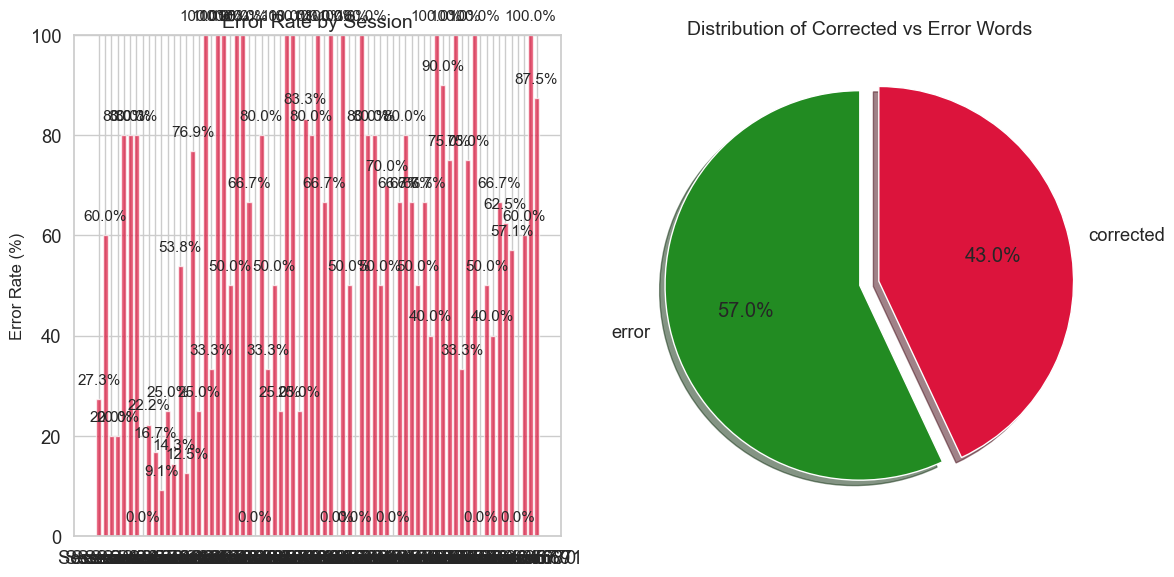

In [8]:
# 1. Error rate comparison between sessions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
session_numbers = [f"Session {i+1}" for i in range(len(sessions))]
error_rates = session_summary_df['error_rate']

plt.bar(session_numbers, error_rates, color='crimson', alpha=0.7)
plt.title('Error Rate by Session', fontsize=14)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.ylim(0, 100)
for i, rate in enumerate(error_rates):
    plt.text(i, rate + 3, f"{rate:.1f}%", ha='center', fontsize=11)

# 2. Corrected vs Error Words distribution
plt.subplot(1, 2, 2)
status_counts = df['reason'].value_counts()
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        colors=['forestgreen', 'crimson'], explode=(0, 0.1), 
        startangle=90, shadow=True)
plt.title('Distribution of Corrected vs Error Words', fontsize=14)

plt.tight_layout()
plt.show()

## 2. Word Length Analysis

Let's examine how word length affects error rates.

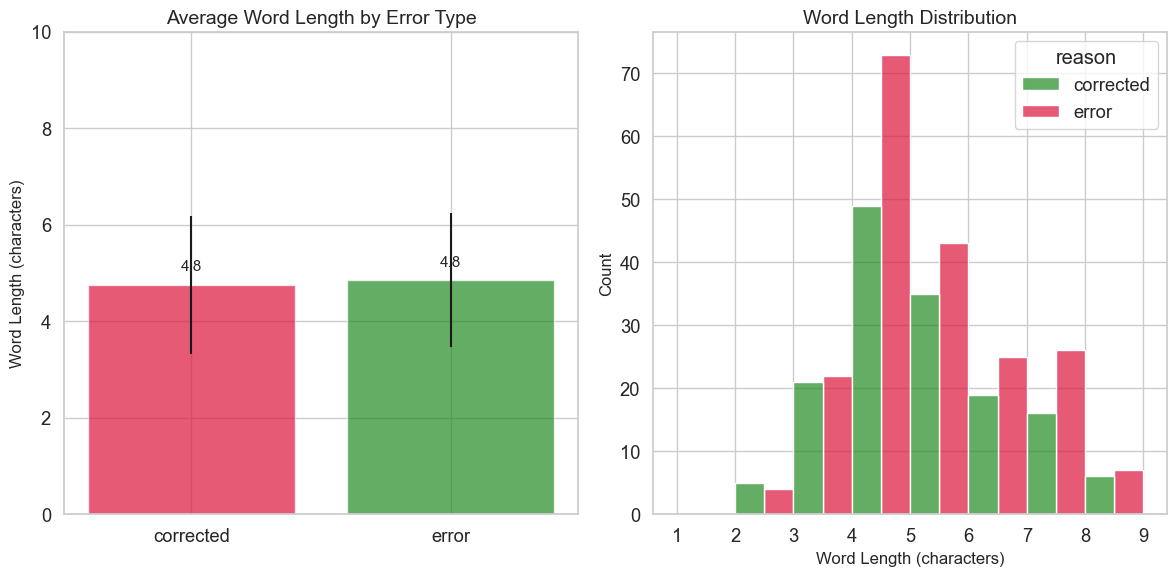

In [9]:
# 3. Word Length Analysis
# Calculate average word length for errors vs corrected
avg_error_length = df[df['reason'] == 'error']['word_length'].mean()
avg_corrected_length = df[df['reason'] == 'corrected']['word_length'].mean()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
reason_groups = df.groupby('reason')
word_length_by_reason = pd.DataFrame({
    'mean': reason_groups['word_length'].mean(),
    'std': reason_groups['word_length'].std()
}).reset_index()

bars = plt.bar(word_length_by_reason['reason'], 
       word_length_by_reason['mean'], 
       yerr=word_length_by_reason['std'],
       color=['crimson', 'forestgreen'],
       alpha=0.7)

plt.title('Average Word Length by Error Type', fontsize=14)
plt.ylabel('Word Length (characters)', fontsize=12)
plt.ylim(0, max(10, df['word_length'].max() + 1))
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height+0.3,
             f'{height:.1f}', ha='center', fontsize=11)

# 4. Word Length Distribution for Errors vs Corrected
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_length', hue='reason', multiple='dodge', 
             palette={'error': 'crimson', 'corrected': 'forestgreen'},
             bins=range(1, 10), alpha=0.7)
plt.title('Word Length Distribution', fontsize=14)
plt.xlabel('Word Length (characters)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Word Cloud Visualization

Let's create word clouds to visualize the most common error words and corrected words.

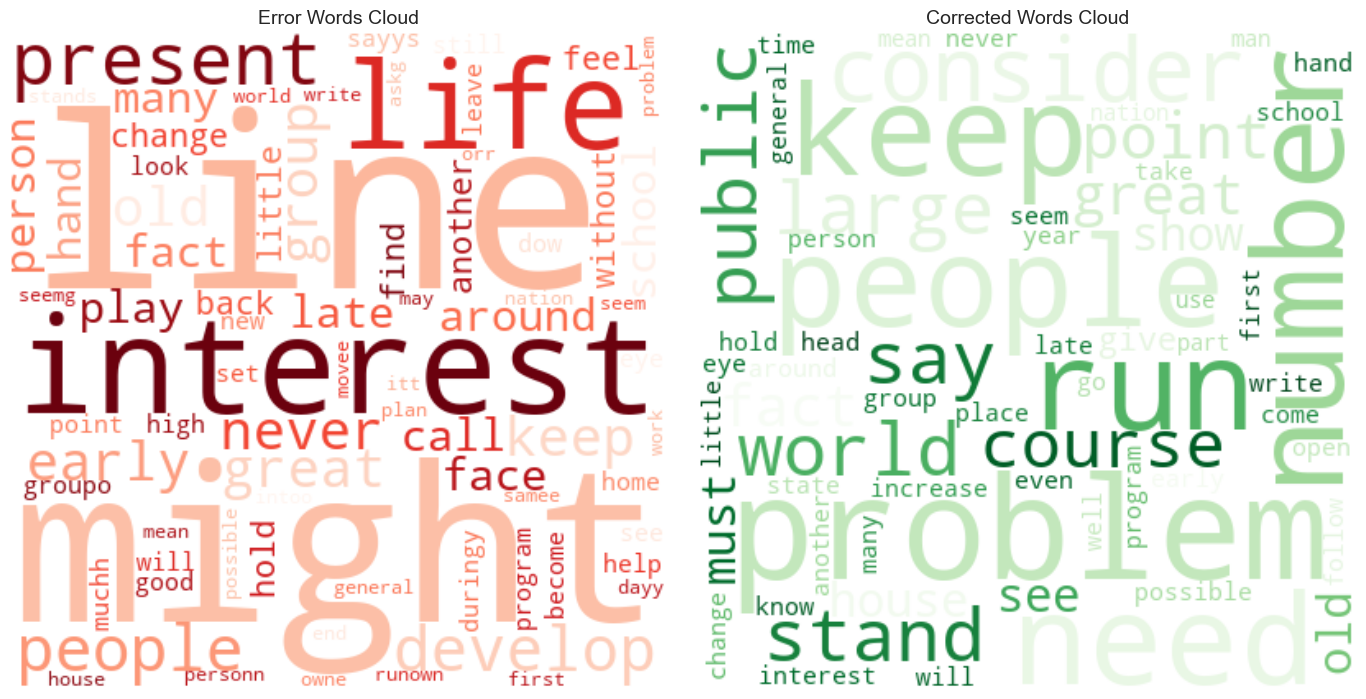

In [10]:
# 5. Create word clouds for error words and corrected words
plt.figure(figsize=(14, 7))

# Error Words Cloud
plt.subplot(1, 2, 1)
error_words_text = ' '.join(df[df['reason'] == 'error']['word'])
if error_words_text:
    error_cloud = WordCloud(width=400, height=400, 
                        background_color='white', 
                        max_words=100,
                        colormap='Reds',
                        contour_width=3, 
                        contour_color='crimson').generate(error_words_text)
    plt.imshow(error_cloud, interpolation='bilinear')
    plt.title('Error Words Cloud', fontsize=14)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No error words to display', 
             horizontalalignment='center', verticalalignment='center',
             fontsize=12)
    plt.title('Error Words Cloud', fontsize=14)
    plt.axis('off')

# Corrected Words Cloud
plt.subplot(1, 2, 2)
corrected_words_text = ' '.join(df[df['reason'] == 'corrected']['word'])
if corrected_words_text:
    corrected_cloud = WordCloud(width=400, height=400, 
                            background_color='white', 
                            max_words=100,
                            colormap='Greens',
                            contour_width=3, 
                            contour_color='forestgreen').generate(corrected_words_text)
    plt.imshow(corrected_cloud, interpolation='bilinear')
    plt.title('Corrected Words Cloud', fontsize=14)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No corrected words to display', 
             horizontalalignment='center', verticalalignment='center',
             fontsize=12)
    plt.title('Corrected Words Cloud', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Letter Frequency Analysis

Let's analyze which letters appear most frequently in error words vs. corrected words.

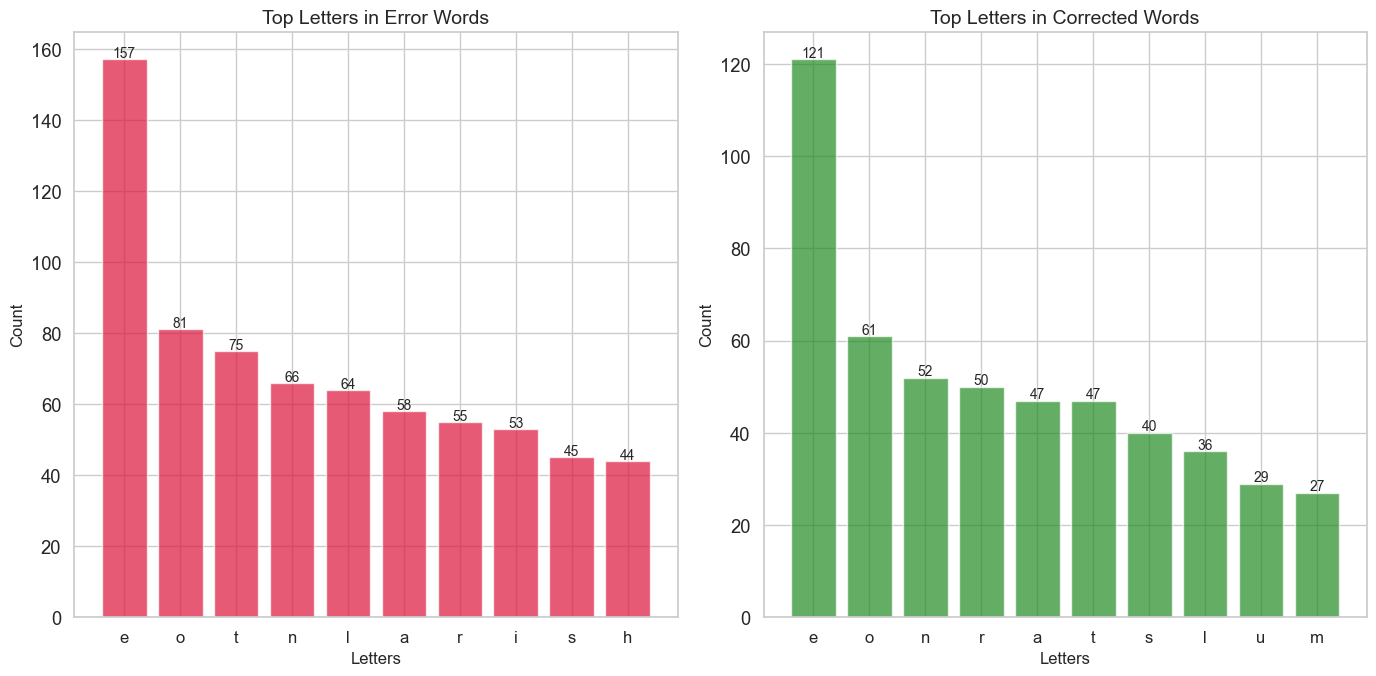

In [11]:
# 6. Common letters in error words
error_words_list = df[df['reason'] == 'error']['word'].tolist()
corrected_words_list = df[df['reason'] == 'corrected']['word'].tolist()

# Function to count letters
def count_letters(word_list):
    letter_counts = {}
    for word in word_list:
        for letter in word:
            if letter.isalpha():
                letter = letter.lower()
                letter_counts[letter] = letter_counts.get(letter, 0) + 1
    return letter_counts

error_letter_counts = count_letters(error_words_list)
corrected_letter_counts = count_letters(corrected_words_list)

# Convert to DataFrames for plotting
error_letters_df = pd.DataFrame(list(error_letter_counts.items()), 
                              columns=['letter', 'count']).sort_values('count', ascending=False)

corrected_letters_df = pd.DataFrame(list(corrected_letter_counts.items()), 
                                  columns=['letter', 'count']).sort_values('count', ascending=False)

# Plot top letters in error words
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
if not error_letters_df.empty:
    top_error_letters = error_letters_df.head(10)
    plt.bar(top_error_letters['letter'], top_error_letters['count'], color='crimson', alpha=0.7)
    plt.title('Top Letters in Error Words', fontsize=14)
    plt.xlabel('Letters', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=12)
    for i, v in enumerate(top_error_letters['count']):
        plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', fontsize=12)
    plt.title('Top Letters in Error Words', fontsize=14)
    plt.axis('off')

# Plot top letters in corrected words
plt.subplot(1, 2, 2)
if not corrected_letters_df.empty:
    top_corrected_letters = corrected_letters_df.head(10)
    plt.bar(top_corrected_letters['letter'], top_corrected_letters['count'], color='forestgreen', alpha=0.7)
    plt.title('Top Letters in Corrected Words', fontsize=14)
    plt.xlabel('Letters', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=12)
    for i, v in enumerate(top_corrected_letters['count']):
        plt.text(i, v + 0.5, str(v), ha='center', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', fontsize=12)
    plt.title('Top Letters in Corrected Words', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 5. Word Frequency Analysis

Let's identify the most common words that cause errors.

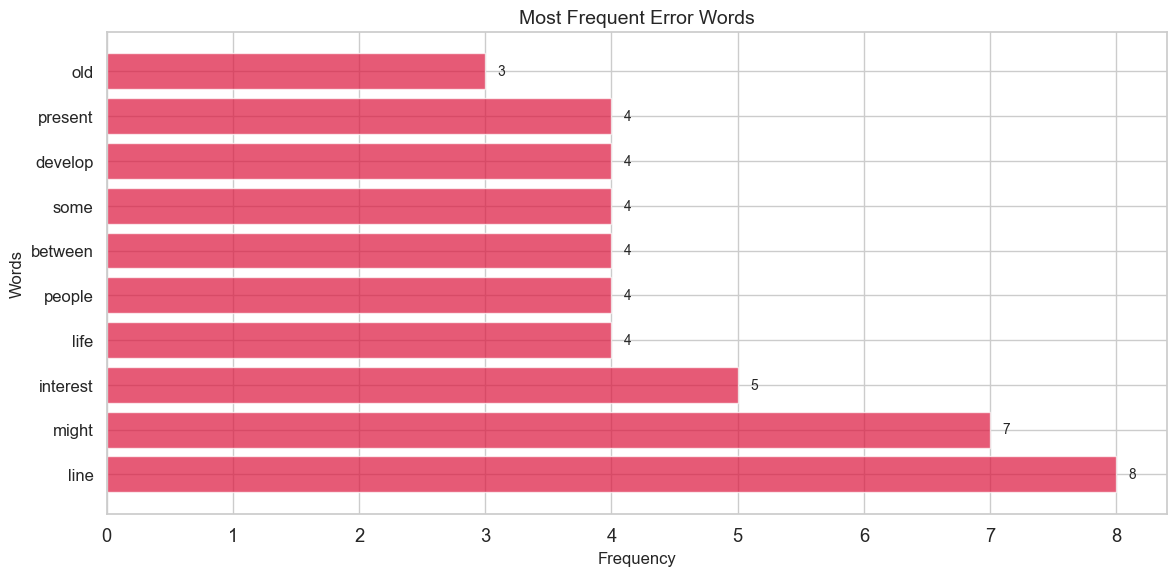

In [12]:
# 7. Word frequency analysis
error_word_freq = df[df['reason'] == 'error']['word'].value_counts().reset_index()
error_word_freq.columns = ['word', 'frequency']

plt.figure(figsize=(12, 6))
if not error_word_freq.empty:
    top_error_words = error_word_freq.head(10)
    plt.barh(top_error_words['word'], top_error_words['frequency'], color='crimson', alpha=0.7)
    plt.title('Most Frequent Error Words', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel('Words', fontsize=12)
    plt.yticks(fontsize=12)
    for i, v in enumerate(top_error_words['frequency']):
        plt.text(v + 0.1, i, str(v), va='center', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No data available', horizontalalignment='center', fontsize=12)
    plt.title('Most Frequent Error Words', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 6. Advanced Metrics Analysis

Let's calculate more detailed metrics about typing performance with different word characteristics.

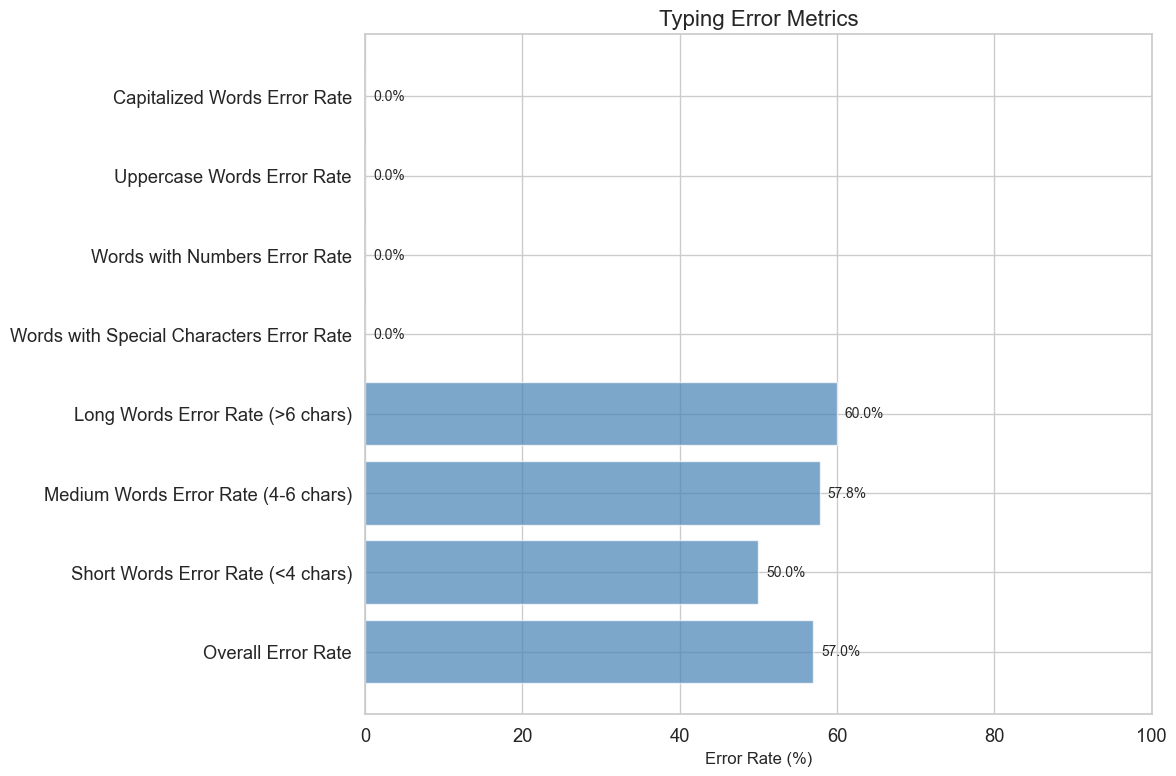

In [13]:
# 8. Calculate metrics for typing performance
# Word complexity analysis
df['has_special_chars'] = df['word'].apply(lambda x: any(not c.isalnum() for c in x))
df['has_numbers'] = df['word'].apply(lambda x: any(c.isdigit() for c in x))
df['is_uppercase'] = df['word'].apply(lambda x: x.isupper())
df['is_capitalized'] = df['word'].apply(lambda x: x[0].isupper() if len(x) > 0 else False)

# Calculate error rates for different word characteristics
def error_rate_for_condition(condition):
    filtered_df = df[condition]
    if len(filtered_df) == 0:
        return 0
    return len(filtered_df[filtered_df['reason'] == 'error']) / len(filtered_df) * 100

metrics = {
    'Overall Error Rate': error_rate,
    'Short Words Error Rate (<4 chars)': error_rate_for_condition(df['word_length'] < 4),
    'Medium Words Error Rate (4-6 chars)': error_rate_for_condition((df['word_length'] >= 4) & (df['word_length'] <= 6)),
    'Long Words Error Rate (>6 chars)': error_rate_for_condition(df['word_length'] > 6),
    'Words with Special Characters Error Rate': error_rate_for_condition(df['has_special_chars']),
    'Words with Numbers Error Rate': error_rate_for_condition(df['has_numbers']),
    'Uppercase Words Error Rate': error_rate_for_condition(df['is_uppercase']),
    'Capitalized Words Error Rate': error_rate_for_condition(df['is_capitalized'])
}

# Create metrics DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

plt.figure(figsize=(12, 8))
plt.barh(metrics_df['Metric'], metrics_df['Value'], color='steelblue', alpha=0.7)
plt.title('Typing Error Metrics', fontsize=16)
plt.xlabel('Error Rate (%)', fontsize=12)
plt.xlim(0, 100)
for i, v in enumerate(metrics_df['Value']):
    plt.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Typing Improvement Recommendations

Based on the analysis, here are some targeted recommendations to improve typing performance.

In [14]:
# 9. Generate typing improvement suggestions based on the analysis
print("\n\n==== TYPING IMPROVEMENT RECOMMENDATIONS ====\n")

# Analyze the most challenging words
if not error_word_freq.empty:
    challenging_words = error_word_freq.head(5)['word'].tolist()
    print(f"🔴 Most Challenging Words: {', '.join(challenging_words)}")
    
    # Word length pattern
    if avg_error_length > avg_corrected_length:
        print(f"📏 Pattern: You tend to make more errors on longer words (average length: {avg_error_length:.1f} characters).")
    elif avg_error_length < avg_corrected_length:
        print(f"📏 Pattern: You interestingly make more errors on shorter words (average length: {avg_error_length:.1f} characters).")
    else:
        print("📏 Word length doesn't seem to significantly impact your error rate.")
else:
    print("🔴 Not enough error data to identify challenging words.")

# Analyze the error patterns by word characteristics
print("\n🔍 Error Patterns by Word Type:")
for metric, value in metrics.items():
    if 'Overall' not in metric and value > error_rate:
        print(f"  - High error rate ({value:.1f}%) for {metric.replace(' Error Rate', '').lower()}")



==== TYPING IMPROVEMENT RECOMMENDATIONS ====

🔴 Most Challenging Words: line, might, interest, life, people
📏 Pattern: You tend to make more errors on longer words (average length: 4.8 characters).

🔍 Error Patterns by Word Type:
  - High error rate (57.8%) for medium words (4-6 chars)
  - High error rate (60.0%) for long words (>6 chars)


In [15]:
# Generate improvement suggestions
print("\n🚀 TYPING IMPROVEMENT SUGGESTIONS:")

# Based on error patterns, provide targeted suggestions
if (
    "Short Words Error Rate" in metrics
    and metrics["Short Words Error Rate"] > error_rate
):
    print(
        "1. Practice precision for short, common words which may receive less attention."
    )

if "Long Words Error Rate" in metrics and metrics["Long Words Error Rate"] > error_rate:
    print(
        "1. For longer words, try breaking them down into syllables in your mind as you type."
    )
    print("2. Practice typing exercises specifically focused on longer words.")

if (
    "Words with Special Characters Error Rate" in metrics
    and metrics["Words with Special Characters Error Rate"] > error_rate
):
    print("1. Dedicate practice time to words with special characters or punctuation.")
    print("2. Work on finger positioning for reaching less common keys.")

# General suggestions
print("\n📝 General Recommendations:")
print("1. Schedule regular typing sessions specifically targeting your problem words.")
print(
    "2. Use focused typing drills that emphasize the challenging words and patterns identified."
)
print(
    "3. Consider advanced typing software that adapts to your specific error patterns."
)
print(
    "4. Practice in short, focused sessions rather than long marathons to maintain concentration."
)
print("5. Monitor your progress by comparing error rates between sessions.")

# Specific technique suggestions
print("\n⌨️ Technique Adjustments:")
print("1. Maintain proper posture with forearms parallel to the floor.")
print("2. Keep your fingers curved and resting lightly on the home row.")
print("3. Look at the screen, not your fingers, to develop muscle memory.")
print("4. Take short breaks to relax your hands and wrists.")
print(
    "5. Start with accuracy over speed - speed will naturally improve as accuracy becomes consistent."
)

# Feature suggestions for the typing software
print("\n🔧 Suggested MonkeyType Features:")
print("1. Personalized practice sets focusing on your specific error words")
print("2. Real-time feedback on error patterns")
print("3. Adaptive difficulty that adjusts based on your performance")
print("4. Progress tracking across multiple metrics")
print("5. Targeted exercises for specific error patterns")


🚀 TYPING IMPROVEMENT SUGGESTIONS:

📝 General Recommendations:
1. Schedule regular typing sessions specifically targeting your problem words.
2. Use focused typing drills that emphasize the challenging words and patterns identified.
3. Consider advanced typing software that adapts to your specific error patterns.
4. Practice in short, focused sessions rather than long marathons to maintain concentration.
5. Monitor your progress by comparing error rates between sessions.

⌨️ Technique Adjustments:
1. Maintain proper posture with forearms parallel to the floor.
2. Keep your fingers curved and resting lightly on the home row.
3. Look at the screen, not your fingers, to develop muscle memory.
4. Take short breaks to relax your hands and wrists.
5. Start with accuracy over speed - speed will naturally improve as accuracy becomes consistent.

🔧 Suggested MonkeyType Features:
1. Personalized practice sets focusing on your specific error words
2. Real-time feedback on error patterns
3. Adapti

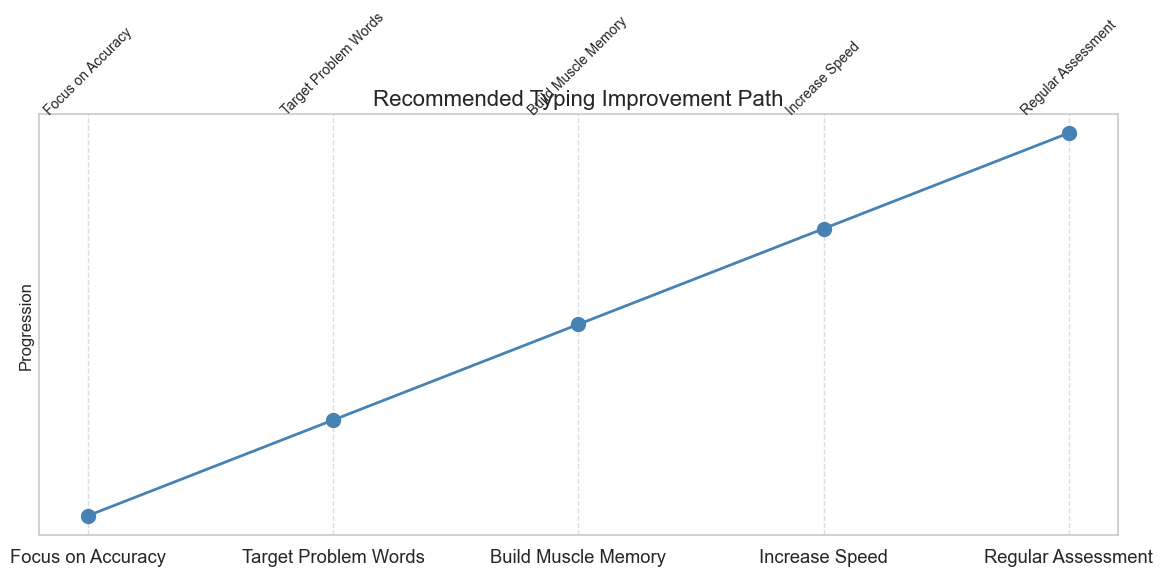


==== SUMMARY METRICS TABLE ====


,Metric,Value
0,Total Words Analyzed,351
1,Total Error Words,200
2,Total Corrected Words,151
3,Overall Error Rate,56.98%
4,Most Common Error Word,line
5,Average Error Word Length,4.8 characters
6,Average Corrected Word Length,4.8 characters
7,Number of Typing Sessions,71
8,Session with Highest Error Rate,Session 18 (100.00%)
9,Session with Lowest Error Rate,Session 8 (0.00%)


In [16]:
# Visualization of improvement path
improvement_stages = [
    "Focus on Accuracy",
    "Target Problem Words",
    "Build Muscle Memory",
    "Increase Speed",
    "Regular Assessment",
]

plt.figure(figsize=(12, 6))
plt.plot(
    improvement_stages,
    [1, 2, 3, 4, 5],
    "o-",
    linewidth=2,
    markersize=10,
    color="steelblue",
)
plt.title("Recommended Typing Improvement Path", fontsize=16)
plt.ylabel("Progression", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.yticks([])

for i, stage in enumerate(improvement_stages):
    plt.text(i, 5.2, stage, ha="center", fontsize=10, rotation=45)

plt.tight_layout()
plt.show()

# Summary metrics table
print("\n==== SUMMARY METRICS TABLE ====")
summary_metrics = {
    "Total Words Analyzed": total_words,
    "Total Error Words": error_words,
    "Total Corrected Words": corrected_words,
    "Overall Error Rate": f"{error_rate:.2f}%",
    "Most Common Error Word": (
        error_word_freq.iloc[0]["word"] if not error_word_freq.empty else "N/A"
    ),
    "Average Error Word Length": f"{avg_error_length:.1f} characters",
    "Average Corrected Word Length": f"{avg_corrected_length:.1f} characters",
    "Number of Typing Sessions": len(sessions),
    "Session with Highest Error Rate": f"Session {session_summary_df['error_rate'].idxmax() + 1} ({session_summary_df['error_rate'].max():.2f}%)",
    "Session with Lowest Error Rate": f"Session {session_summary_df['error_rate'].idxmin() + 1} ({session_summary_df['error_rate'].min():.2f}%)",
}

summary_df = pd.DataFrame(list(summary_metrics.items()), columns=["Metric", "Value"])
summary_df